# Effect of randomized response
We compare counts with and without randomized response to see if it impacts bias

In [34]:
import random

def randomizedResponse(truth):
    if (random.random() < 0.5):
        return truth
    else:
        return random.random() < 0.5


In [3]:
import sqlite3

conn = sqlite3.connect("medical.db")
cur = conn.cursor()

In [39]:
import pandas as pd

dfFPreg = pd.read_sql_query("""
SELECT DISTINCT COUNT(p.patient) AS count FROM conditions c
JOIN patients p ON c.patient = p.patient
WHERE description = 'Coronary Heart Disease' AND p.gender = 'F'
""", conn)

dfMPreg = pd.read_sql_query("""
SELECT DISTINCT COUNT(p.patient) AS count FROM conditions c
JOIN patients p ON c.patient = p.patient
WHERE description = 'Coronary Heart Disease' AND p.gender = 'M'
""", conn)

dfF = pd.read_sql_query("""
SELECT DISTINCT COUNT(patient) AS count FROM patients
WHERE gender = 'F'
""", conn)

dfM = pd.read_sql_query("""
SELECT DISTINCT COUNT(patient) AS count FROM patients
WHERE gender = 'M'
""", conn)

dfF.at[0, 'count']
dfM.at[0, 'count']
dfFPreg.at[0, 'count']
dfMPreg.at[0, 'count']

pregF = dfFPreg.at[0, 'count']
notPregF = dfF.at[0, 'count'] - pregF
pregM = dfMPreg.at[0, 'count']
notPregM = dfM.at[0, 'count'] - pregM

randF = 0

for x in range(pregF):
    if randomizedResponse(True):
        randF = randF + 1
for x in range(notPregF):
    if randomizedResponse(False):
        randF = randF + 1

print(pregF, randF)

randM = 0

for x in range(pregM):
    if randomizedResponse(True):
        randM = randM + 1
for x in range(notPregM):
    if randomizedResponse(False):
        randM = randM + 1

print(pregM, randM)

23 190
75 220


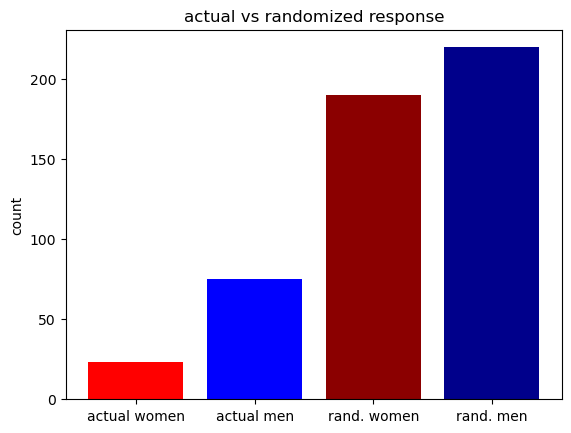

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fruits = ['actual women', 'actual men', 'rand. women', 'rand. men']
counts = [pregF, pregM, randF, randM]
bar_colors = ['red', 'blue', 'darkred', 'darkblue']

ax.bar(fruits, counts, color=bar_colors)

ax.set_ylabel('count')
ax.set_title('actual vs randomized response')

plt.show()

Actually there are three times as many men with this heart disease but after randomized response this difference becomes totally diluted. This is why we must subtract how many we expect to answer fake yes and mulitply by 2

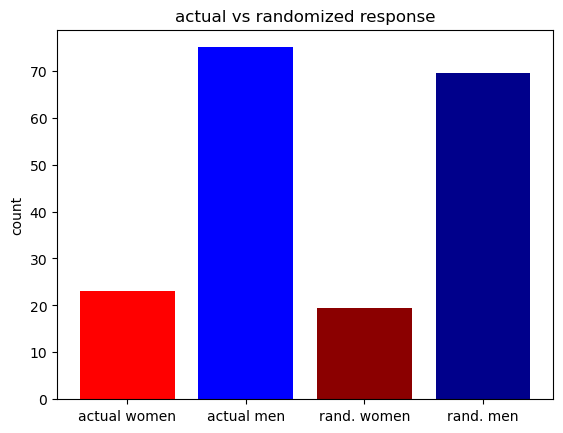

In [41]:
womenFakeYesses = dfF.at[0, 'count'] / 4
menFakeYesses = dfM.at[0, 'count'] / 4

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fruits = ['actual women', 'actual men', 'rand. women', 'rand. men']
counts = [pregF, pregM, (randF - womenFakeYesses) * 2, (randM - menFakeYesses) * 2]
bar_colors = ['red', 'blue', 'darkred', 'darkblue']

ax.bar(fruits, counts, color=bar_colors)

ax.set_ylabel('count')
ax.set_title('actual vs randomized response')

plt.show()

After subtracting the fake yesses the bias is intact